A multi-layer perceptron approach to predicting coordinates of street view images. Must generate image embeddings before running. 

In [25]:
import os
import pandas as pd
import random
from PIL import Image
import numpy as np
from tqdm import tqdm
import requests
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import random_split
import torch
import dask.dataframe as dd
import io
import folium
from matplotlib import pyplot as plt

In [13]:
coords = pd.read_csv('coordinates.csv')
image_feats = np.load('image_embeddings.npy')

# will use later for normalizing coordinate inputs
lat_min = coords["latitude"].min()
lat_max = coords["latitude"].max()
lon_min = coords["longitude"].min()
lon_max = coords["longitude"].max()

In [14]:
# functions to normalize/denormalize coordinates to [0,1]

def normalize_coords(lat,lon):
    # Normalize to [0, 1]
    lat_norm = (lat - lat_min) / (lat_max - lat_min)
    lon_norm = (lon - lon_min) / (lon_max - lon_min)

    return lat_norm,lon_norm

def denormalize_coords(lat_norm,lon_norm):
    # If [0, 1] normalization
    lat = lat_norm * (lat_max - lat_min) + lat_min
    lon = lon_norm * (lon_max - lon_min) + lon_min

    return lat,lon

In [15]:
class StreetviewEmbeddingsDataset(Dataset):
    '''
    Dataset of streetview image StreetCLIP embeddings and corresponding coordinates
    '''
    def __init__(self, embeddings_path, coords):
        self.embeddings_path = embeddings_path
        self.coords = coords

    def __len__(self):
        return len(self.coords) - 1

    def __getitem__(self, idx):
        # Get target lat/lon
        lat = torch.tensor(self.coords.iloc[idx]["latitude"], dtype=torch.float32)
        lon = torch.tensor(self.coords.iloc[idx]["longitude"], dtype=torch.float32)

        lat_norm,lon_norm = normalize_coords(lat,lon)

        target = torch.stack([lat_norm, lon_norm])

        embedding = self.embeddings_path[idx]
        embedding_tensor = torch.from_numpy(embedding).float()

        return embedding_tensor, target.float()

In [16]:
# initialize the dataset

dataset  = StreetviewEmbeddingsDataset(image_feats, coords)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define MLP
regressor = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Sigmoid()
).to(device)

# haversine loss function
def haversine_loss(pred, true):
    """
    pred and true should be (N, 2) tensors containing [latitude, longitude] in degrees
    Returns: (N,) tensor of distances in kilometers
    """

    # Denormalize the predictions
    lat_pred = pred[:, 0] * (lat_max - lat_min) + lat_min
    lon_pred = pred[:, 1] * (lon_max - lon_min) + lon_min

    # Stack to form the denormalized predictions
    denormalized_prediction = torch.stack([lat_pred, lon_pred], dim=1)

    # Denormalize the ground truth
    lat_true = true[:, 0] * (lat_max - lat_min) + lat_min
    lon_true = true[:, 1] * (lon_max - lon_min) + lon_min

    # Stack to form the ground truth
    denormalized_truth = torch.stack([lat_true, lon_true], dim=1)


    # calculate haversine distance
    R = 6371.0  # Earth radius in km

    pred_rad = torch.deg2rad(denormalized_prediction)
    true_rad = torch.deg2rad(denormalized_truth)

    dlat = pred_rad[:, 0] - true_rad[:, 0]
    dlon = pred_rad[:, 1] - true_rad[:, 1]

    a = torch.sin(dlat / 2) ** 2 + \
        torch.cos(true_rad[:, 0]) * torch.cos(pred_rad[:, 0]) * torch.sin(dlon / 2) ** 2

    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    distance = R * c

    return distance.mean()

# define hyper parameters
opt = torch.optim.Adam(regressor.parameters(), lr=1e-4)
MSEloss = nn.MSELoss()

In [18]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    opt.zero_grad()                    # Flush memory
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

In [19]:
# train MLP on image embeddings
n_epochs = 10

for epoch in range(n_epochs):
    print(f"Running epoch {epoch + 1} of {n_epochs}")

    epoch_losses = []

    # train
    for batch in loader:
        x, y = batch
        batch_loss = train_batch(x, y, regressor, opt, haversine_loss) # using Haversine loss, can also use MSELoss
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses)

    print('loss (km)',epoch_loss)

Running epoch 1 of 10
loss (km) 3564.388
Running epoch 2 of 10
loss (km) 2056.6472
Running epoch 3 of 10
loss (km) 1798.3989
Running epoch 4 of 10
loss (km) 1638.9595
Running epoch 5 of 10
loss (km) 1531.5596
Running epoch 6 of 10
loss (km) 1452.9757
Running epoch 7 of 10
loss (km) 1398.9963
Running epoch 8 of 10
loss (km) 1349.3586
Running epoch 9 of 10
loss (km) 1311.77
Running epoch 10 of 10
loss (km) 1278.7355


In [20]:
# access HuggingFace streetview dataset to test KNN coordinate predictions
# https://huggingface.co/datasets/stochastic/random_streetview_images_pano_v0.0.2

test_images = dd.read_parquet("hf://datasets/stochastic/random_streetview_images_pano_v0.0.2/data/train-*-of-*.parquet")
row0 = test_images.head(1000)  # returns a Pandas DataFrame with the first 1000 images

In [21]:
# set up StreetCLIP model to test new images with

street_clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP").to(device)
street_clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

def embed_image(byte_encoding):
    '''
    Generate an image embedding using StreetCLIP. Uses the images byte encoding

    args: the image byte encoding
    returns: a tensor of the image embedding
    '''
    # Load image
    image = Image.open(io.BytesIO(byte_encoding)).convert('RGB')

    # Process image
    inputs = street_clip_processor(images=image, return_tensors="pt", padding=True)
    for k in inputs:
        inputs[k] = inputs[k].to(device)

    with torch.no_grad():
        image_feat = street_clip_model.get_image_features(**inputs)
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)

    return image_feat.squeeze(0)

def haversine_distance_single_pair(true_lat, true_lon, pred_lat, pred_lon):
    '''
    Computes haversine distance between two points, use for testing one pair of points
    
    Parameters:
    - true_lat, true_lon: float (degrees)
    - pred_lat, pred_lon: float (degrees)
    
    Returns:
    - distance in kilometers (float)
    '''
    R = 6371.0  # Earth radius in km

    # Convert degrees to radians
    true_lat_rad = np.deg2rad(true_lat)
    true_lon_rad = np.deg2rad(true_lon)
    pred_lat_rad = np.deg2rad(pred_lat)
    pred_lon_rad = np.deg2rad(pred_lon)

    # Differences
    dlat = pred_lat_rad - true_lat_rad
    dlon = pred_lon_rad - true_lon_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(true_lat_rad) * np.cos(pred_lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


pred coords 47.802536 12.210953
true coords 47.3019355 8.6403476
error (km) 273.65829319311456


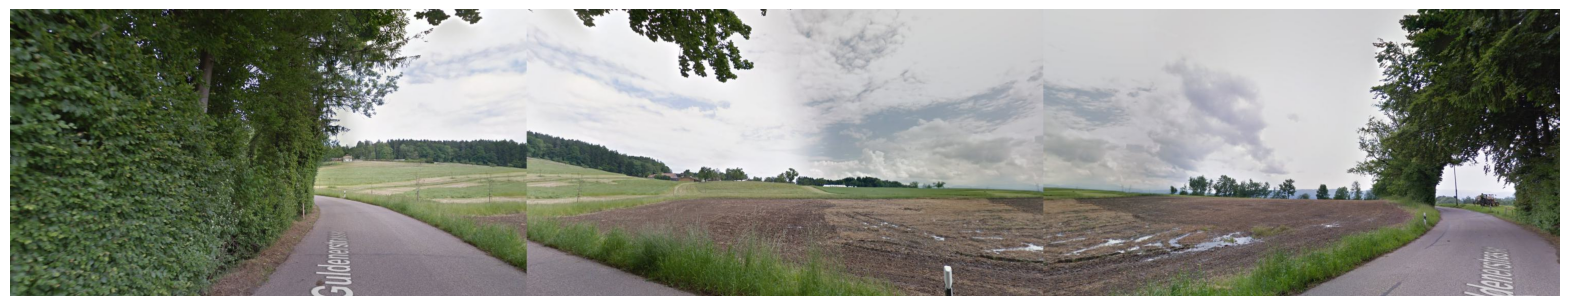

In [33]:
# test the MLP prediction

rand = random.randint(0,999)

# parse HuggingFace dataset
true_lat = row0.iloc[rand]['latitude']
true_lon = row0.iloc[rand]['longitude']
img = row0.iloc[rand]['image'] # image is stored as a byte encoding
address = row0.iloc[rand]['address']

# generate image embedding
embedding = embed_image(img['bytes'])

# run regressor
pred_coords = regressor(embedding)
pred_lat,pred_lon = denormalize_coords(pred_coords[0],pred_coords[1])
pred_lat = pred_lat.detach().numpy()
pred_lon = pred_lon.detach().numpy()

# create map
m = folium.Map(location=(true_lat, true_lon))

# add ground truth coordinates
folium.Marker(
    [true_lat, true_lon],
    popup="Ground Truth",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# add predicted coordinates
folium.Marker(
    [pred_lat, pred_lon],
    popup="Prediction",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

print('pred coords',pred_lat,pred_lon)
print('true coords',true_lat,true_lon)

print('error (km)', haversine_distance_single_pair(float(true_lat), float(true_lon), pred_lat, pred_lon))

# open image in a new window
streetview = Image.open(io.BytesIO(img['bytes'])).convert('RGB')
plt.figure(figsize=(20, 10))
plt.imshow(streetview)
plt.axis('off')  # Hide the axes
plt.show()

# display map
m

In [60]:
# test regressor on 10 random images from HuggingFace streetview dataset

total_error = np.zeros(10)

for i in range(10):
    rand = random.randint(0,999)

    # parse HuggingFace dataset
    true_lat = row0.iloc[rand]['latitude']
    true_lon = row0.iloc[rand]['longitude']
    img = row0.iloc[rand]['image'] # image is stored as a byte encoding
    address = row0.iloc[rand]['address']

    # generate image embedding
    embedding = embed_image(img['bytes'])

    # run KNN 
    pred_coords = regressor(embedding)
    pred_lat,pred_lon = denormalize_coords(pred_coords[0],pred_coords[1])
    pred_lat = pred_lat.detach().numpy()
    pred_lon = pred_lon.detach().numpy()

    print('pred',pred_lat,pred_lon)
    print('true',true_lat, true_lon)
    error = haversine_distance_single_pair(float(true_lat), float(true_lon),pred_lat,pred_lon)
    total_error[i] = error
    print('error (km)',error)
    print('--------------')

print('average error (km)', np.mean(total_error))

pred -34.958054 -67.02402
true -47.7939291 -70.8289331
error (km) 1461.680719968416
--------------
pred 53.58374 48.77768
true 57.6012572 39.8765501
error (km) 714.8384229762515
--------------
pred 16.717308 99.71855
true 22.254943 113.913803
error (km) 1609.2701250828693
--------------
pred 60.797478 30.135788
true 63.0338146 23.9698275
error (km) 407.17001522845896
--------------
pred 50.22065 9.857956
true 50.8023156 3.3604827
error (km) 463.8202353997078
--------------
pred 51.965256 7.345993
true 56.3841469 23.7408113
error (km) 1170.9377717620712
--------------
pred 35.37587 130.88387
true 35.1078956 136.9538505
error (km) 551.9660779699158
--------------
pred 9.706917 81.712265
true 22.8233179 89.3411026
error (km) 1669.305082009338
--------------
pred 37.917725 128.01488
true 37.406581 127.0795934
error (km) 100.04059332377943
--------------
pred 52.650703 18.921814
true 61.0449791 24.9405562
error (km) 1001.5854368312711
--------------
average error (km) 915.0614480552078
